In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# NB: Score of accuracy on test obtained is : 75%

# I tried to comment and explain my code, feel free to ask if something isn't clear

In [ ]:

import pandas as pd

df_train = pd.read_excel (r'/content/drive/My Drive/Colab Notebooks/case3_jumia_application.xlsx', sheet_name='training')

df_test = pd.read_excel (r'/content/drive/My Drive/Colab Notebooks/case3_jumia_application.xlsx', sheet_name='testing')

In [ ]:
df_train.shape, df_test.shape

((114999, 16), (43196, 16))

We perform some data cleaning

In [ ]:
#we drop rows where we have valid orders but no information about last order

index_names =  df_train[(df_train['last_order_number_items'].isnull())  &   (df_train['valid_orders'] > 0)].index

df_train.drop(index_names, inplace = True) 

index_names =  df_train[(df_train['last_order_date'].isnull())  &   (df_train['valid_orders'] > 0)].index

df_train.drop(index_names, inplace = True) 

#we drop rows where we don't have valid_orders, but still the user spent money!
index_names =  df_train[(df_train['valid_orders'].isnull())  &   (df_train['NMV'] > 0)].index

df_train.drop(index_names, inplace = True) 

#we drop rows where the user never spent money, but still have valid orders

index_names =  df_train[(df_train['NMV'].isnull())  &   (df_train['valid_orders'] > 0)].index

df_train.drop(index_names, inplace = True) 


df_train.head(200)

user_id  app_user  num_visits_past_30_d  ...   food    pay  ordered_14d
0    1167749         0                     6  ...  False   True            1
2    8676593         1                     2  ...  False  False            0
3    8722761         1                     1  ...  False  False            0
4    6768479         0                     1  ...  False   True            0
5    9099383         0                    72  ...  False   True            1
..       ...       ...                   ...  ...    ...    ...          ...
206  9486410         1                     1  ...  False   True            0
207  9732437         1                     6  ...  False   True            0
208  4839398         1                     9  ...  False   True            0
209  9014630         1                     1  ...  False  False            0
210  4691323         1                     1  ...  False   True            0

[200 rows x 16 columns]

In [ ]:
df_train['cod_customer_gender'].unique()

array(['male', 'female', nan], dtype=object)

In [ ]:
max = df_train['last_order_date'].max()
min = df_train['last_order_date'].min()
l = str(max - min)

<Figure size 864x504 with 0 Axes>

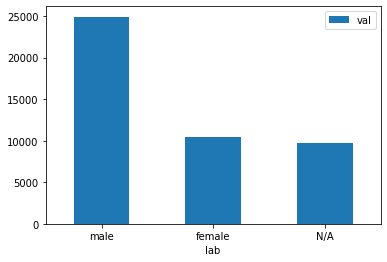

In [ ]:
import matplotlib.pyplot as plt

import numpy as np

df_train.drop(columns=['user_id'], inplace = True)


fig = plt.figure(1, figsize=(12, 7))
#the number of users that ordered_14d per gender
num_male_lucky = np.sum(df_train[df_train['cod_customer_gender'] =='male'].ordered_14d)

num_female_lucky = np.sum(df_train[df_train['cod_customer_gender'] =='female'].ordered_14d)

num_none_lucky = np.sum(df_train[df_train['cod_customer_gender'].isnull()].ordered_14d)

num_none_lucky

df = pd.DataFrame({'lab':['male' , 'female', 'N/A'], 'val':[num_male_lucky, num_female_lucky, num_none_lucky]})
ax = df.plot.bar(x='lab', y='val', rot=0)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


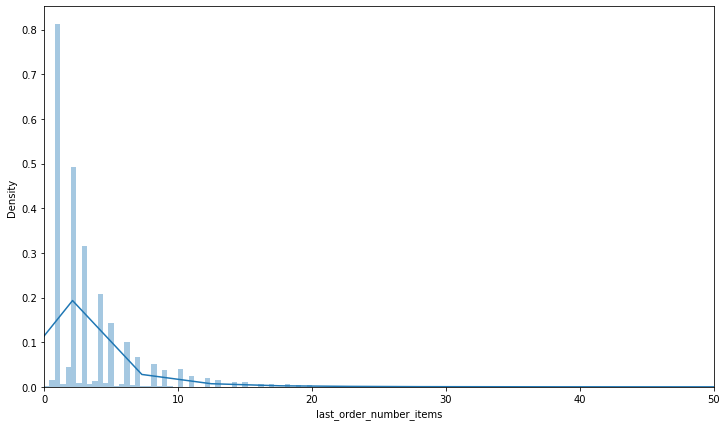

In [ ]:
#here we plot the distribution of the number of last ordered items 

import seaborn as sns


import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(12, 7))

#ax = df_train['last_order_number_items'].plot.kde(kde_kws={'clip': (0.0, 10)})
plt.xlim(0, 50)

sns.distplot(df_train['last_order_number_items'], hist=True, hist_kws={'range': (0.0, 20)})

In [ ]:
from sklearn.preprocessing import MinMaxScaler


#this fucntion applies generic transformation on df_train and df_test
def transform_features(df):

  #we will transform the column 'last_order_date' into a numerical value: number of days since the last order
  max = df['last_order_date'].max()
  df['last_order_date'] = max - df['last_order_date']
  df['last_order_date']=  df['last_order_date'].apply(lambda x: x.days )

  #for the users that never ordered before, we decided to affect a very high number to the column last_order_date: 500000
  df['last_order_date'] = df['last_order_date'].fillna(500000)

  #when the user have never done an order before, we fill the number of valid orders column with 0, same for the number of the last ordered items and NMV
  df['valid_orders'] = df['valid_orders'].fillna(0)
  df['last_order_number_items'] = df['last_order_number_items'].fillna(0)
  df['NMV'] = df['NMV'].fillna(0)

  # we encode the categorical columns "cod_customer_gender" and "category1_reco" using the one hot encoding
  df = pd.get_dummies(df, columns=["cod_customer_gender", "category1_reco"], prefix=["cod_customer_gender", "category1_reco"])

  return(df)


df_train = transform_features(df_train)
# we scale the numerical features

mms = MinMaxScaler()
df_train[['NMV','last_order_date', 'num_product_views' , 'num_add_to_cart', 'num_visits_past_30_d' ,'last_order_number_items', 'recency_visit' , 'valid_orders']] = mms.fit_transform(df_train[['NMV','last_order_date', 'num_product_views' , 'num_add_to_cart', 'num_visits_past_30_d' ,'last_order_number_items', 'recency_visit', 'valid_orders']])
  
  





In [ ]:
df_train.head()

app_user  ...  category1_reco_Women_Fashion
0         0  ...                             0
2         1  ...                             0
3         1  ...                             1
4         0  ...                             0
5         0  ...                             0

[5 rows x 25 columns]

<Figure size 864x504 with 0 Axes>

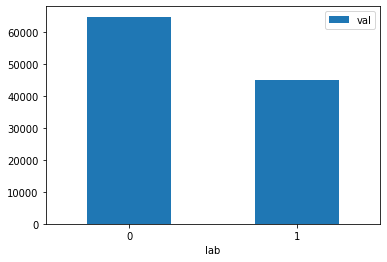

In [ ]:
df_train
fig = plt.figure(1, figsize=(12, 7))

df = pd.DataFrame({'lab':['0' , '1'], 'val':[len(df_train[df_train['ordered_14d'] ==0].ordered_14d), len(df_train[df_train['ordered_14d'] ==1].ordered_14d)]})
ax = df.plot.bar(x='lab', y='val', rot=0)


In [ ]:
#we define the features matric and the target matrix

X, y = df_train[df_train.columns.difference(['ordered_14d'])].values,df_train['ordered_14d'].values

X = np.asarray(X).astype(np.float32)



In [ ]:
X.shape,  y.shape

((109746, 24), (109746,))

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

#we split our data set df_train into train and test sets in order to validate our model
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)


We will try 3 classification algorithms, we have 2 classes : 0: the user is notgoing to oder, 1 the user is going to order

To this end, we will, try Xgboost classifier, random forest classifier, and finally a fully connected network

# XGboost classifier

In [ ]:
D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)

In [ ]:
#we define our classifiers parameters, (we could have performed a grid search cv to find optimal parameters)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 20  # The number of training iterations

In [ ]:
model = xgb.train(param, D_train, steps)


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds_xg = model.predict(D_test)
best_preds_xg = np.asarray([np.argmax(line) for line in preds])

print("Precision on test set= {}".format(precision_score(Y_test, best_preds_xg, average='macro')))
print("Recall on test set= {}".format(recall_score(Y_test, best_preds_xg, average='macro')))
print("Accuracy on test set= {}".format(accuracy_score(Y_test, best_preds_xg)))

Precision on test set= 0.50082271326637
Recall on test set= 0.5007996481404283
Accuracy on test set= 0.5218678815489749


For XGboost, we have a **75% accuracy** on test set




In [ ]:
pred_train_xg = model.predict(D_train)
best_preds_xg_train = np.asarray([np.argmax(line) for line in pred_train])

print("Precision on train= {}".format(precision_score(Y_train, best_preds_xg_train, average='macro')))
print("Recall on train= {}".format(recall_score(Y_train, best_preds_xg_train, average='macro')))
print("Accuracy on train= {}".format(accuracy_score(Y_train, best_preds_xg_train)))

Precision on train= 0.4997277177816337
Recall on train= 0.4997348578976066
Accuracy on train= 0.5213563260285207


### Classification report for XGboost

In [ ]:
print(classification_report(Y_train,best_preds_xg_train))
print('test data')
print(classification_report(Y_test, best_preds_xg ))

              precision    recall  f1-score   support

           0       0.59      0.62      0.60     51795
           1       0.41      0.38      0.39     36001

    accuracy                           0.52     87796
   macro avg       0.50      0.50      0.50     87796
weighted avg       0.52      0.52      0.52     87796

test data
              precision    recall  f1-score   support

           0       0.59      0.62      0.60     12899
           1       0.41      0.38      0.40      9051

    accuracy                           0.52     21950
   macro avg       0.50      0.50      0.50     21950
weighted avg       0.52      0.52      0.52     21950



# Random forest

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

seed= 0

clf=RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=5, min_samples_split=2,
  min_samples_leaf=1, max_features='auto',    bootstrap=False, oob_score=False, n_jobs=1, random_state=seed,
  verbose=0)

param_grid = dict( )
pipeline=Pipeline([ ('clf',clf) ])
strarifiedCV = StratifiedShuffleSplit(n_splits=10,test_size=0.2, random_state=0)
grid_search = GridSearchCV(pipeline,param_grid=param_grid,verbose=3,scoring='accuracy',
                           cv =strarifiedCV,).fit(X_train, Y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.742, total=  18.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.9s remaining:    0.0s


[CV] .................................... , score=0.747, total=  18.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.8s remaining:    0.0s


[CV] .................................... , score=0.749, total=  18.8s
[CV]  ................................................................
[CV] .................................... , score=0.750, total=  18.6s
[CV]  ................................................................
[CV] .................................... , score=0.745, total=  18.6s
[CV]  ................................................................
[CV] .................................... , score=0.745, total=  18.4s
[CV]  ................................................................
[CV] .................................... , score=0.746, total=  18.4s
[CV]  ................................................................
[CV] .................................... , score=0.744, total=  18.8s
[CV]  ................................................................
[CV] .................................... , score=0.749, total=  18.6s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.1min finished


In [ ]:
print("Best score: %0.3f" % grid_search.best_score_)
print(grid_search.best_estimator_)
from sklearn.model_selection import cross_val_score 

 
print('-----grid search end------------')
print ('on all train set')
scores = cross_val_score(grid_search.best_estimator_, X_train, Y_train,cv=3,scoring='accuracy')
print (scores.mean(),scores)
print ('on test set')
scores = cross_val_score(grid_search.best_estimator_, X_test, Y_test,cv=3,scoring='accuracy')
print (scores.mean(),scores)

Best score: 0.746
Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=5, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=1,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)
-----grid search end------------
on all train set
0.7459110018423812 [0.74359325 0.74836836 0.7457714 ]
on test

### Classification report for random foresr

In [ ]:
print(classification_report(Y_train, grid_search.best_estimator_.predict(X_train) ))
print('test data')
print(classification_report(Y_test, grid_search.best_estimator_.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79     51795
           1       0.71      0.65      0.68     36001

    accuracy                           0.75     87796
   macro avg       0.74      0.73      0.73     87796
weighted avg       0.74      0.75      0.75     87796

test data
              precision    recall  f1-score   support

           0       0.77      0.81      0.79     12899
           1       0.71      0.65      0.68      9051

    accuracy                           0.74     21950
   macro avg       0.74      0.73      0.73     21950
weighted avg       0.74      0.74      0.74     21950



We conclude that for random forest, the accuracy on test set is **75 %**

# Fully connected neural network classifier

In [ ]:
from keras import Sequential
from keras.layers import Dense

classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(30, activation='relu', kernel_initializer='random_normal', input_dim=24))
#Second  Hidden Layer
classifier.add(Dense(30, activation='relu', kernel_initializer='random_normal'))
#Second  Hidden Layer
classifier.add(Dense(15, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(5, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [ ]:
#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [ ]:
#Fitting the data to the training dataset
classifier.fit(X_train,Y_train, batch_size=100, epochs=30)

Epoch 1/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5886 - accuracy: 0.6760
Epoch 2/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5580 - accuracy: 0.7148
Epoch 3/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5472 - accuracy: 0.7216
Epoch 4/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5413 - accuracy: 0.7244
Epoch 5/30
878/878 [==============================] - 2s 3ms/step - loss: 0.5392 - accuracy: 0.7257
Epoch 6/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5374 - accuracy: 0.7269
Epoch 7/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5366 - accuracy: 0.7269
Epoch 8/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5359 - accuracy: 0.7280
Epoch 9/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5347 - accuracy: 0.7274
Epoch 10/30
878/878 [==============================] - 2s 2ms/step - loss: 0.5335 - accuracy: 0.7268

In [ ]:
eval_model=classifier.evaluate(X_train, Y_train)

# loss andaccuracy of the model on training set
eval_model

2744/2744 [==============================] - 4s 2ms/step - loss: 0.5268 - accuracy: 0.7314


[0.5267930626869202, 0.7313659191131592]

In [ ]:
y_pred=classifier.predict(X_test)
y_pred =(y_pred>0.5)

In [ ]:
print("Precision = {}".format(precision_score(Y_test, y_pred, average='macro')))
print("Recall = {}".format(recall_score(Y_test, y_pred, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, y_pred)))

Precision = 0.7316127957307706
Recall = 0.7123671300605285
Accuracy = 0.7350797266514807


### Classification report for FNN classifier

In [ ]:
print(classification_report(Y_train, (classifier.predict(X_train)>0.5)))
print('test data')
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79     51795
           1       0.72      0.57      0.64     36001

    accuracy                           0.73     87796
   macro avg       0.73      0.71      0.71     87796
weighted avg       0.73      0.73      0.72     87796

test data
              precision    recall  f1-score   support

           0       0.74      0.84      0.79     12899
           1       0.72      0.58      0.64      9051

    accuracy                           0.74     21950
   macro avg       0.73      0.71      0.72     21950
weighted avg       0.73      0.74      0.73     21950



The accuracy of the FNN classifier is **74 %** on the test set

Now we can use the previous model to fill the column 'ordered_14d' for the testing excel sheet


**bold text**

In [ ]:
df_test = df_test.rename(columns={'num_product_views_30_d': 'num_product_views', 'num_add_to_cart_30_d':'num_add_to_cart'})

df_test = transform_features(df_test)

df_test[['NMV','last_order_date', 'num_product_views' , 'num_add_to_cart', 'num_visits_past_30_d' ,'last_order_number_items', 'recency_visit' , 'valid_orders']] = mms.transform(df_test[['NMV','last_order_date', 'num_product_views' , 'num_add_to_cart', 'num_visits_past_30_d' ,'last_order_number_items', 'recency_visit', 'valid_orders']])



In [ ]:
df_test.drop(columns=['user_id'], inplace = True)

#this vector gathers the predictions for the testing excel sheet
predictions = grid_search.best_estimator_.predict(df_test[df_test.columns.difference(['ordered_14d'])].values)


In [ ]:
predictions

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
len(predictions) , df_test.shape

(43196, (43196, 25))

### Conclusion:

We could achieve an accuracy of 75% on test set, though, this performance could be improved using more sophisticated classification models and trying to understand and encode better the features.

In [ ]:
df_test_end = pd.read_excel (r'/content/drive/My Drive/Colab Notebooks/case3_jumia_application.xlsx', sheet_name='testing')
df_test_end['ordered_14d'] = predictions


In [ ]:
#ratio of people who will order in the next 15 days

np.sum(df_test_end.ordered_14d) / len(df_test_end.ordered_14d)

0.36288082229836094

In [ ]:
# create excel writer object
writer = pd.ExcelWriter('/content/drive/My Drive/Colab Notebooks/jumia_case_testing_filled.xlsx')
df.to_csv(r'/content/drive/My Drive/Colab Notebooks/descar.csv', index = False)

# write dataframe to excel
df_test_end.to_excel(writer)
# save the excel
writer.save()